Bayesian model fitting for a mixture of two Gaussians.
For simplicity, I assume that we know the mixture ratio is 1/2 and the variances of the two Gaussians are 1.
We'd like to estimate the means of the two distributions: $\mu_1$, $\mu_2$.
Each data point $y_i$ is modeled as:
$$
p(y_i | \mu_1, \mu_2) = \frac{1}{2}\mathcal{N}(y_i;\mu_1, 1) + \frac{1}{2}\mathcal{N}(y_i;\mu_2, 1)
$$

Alternatively, we can include the latent indicator variables $z_i\in\{1,2\}$ so that
\begin{align}
p(z_i = 1) = p(z_i = 2) & = \frac{1}{2}\\
p(y_i | \mu_1, \mu_2, z_i) & = \mathcal{N}(y_i;\mu_{z_i}, 1) 
\end{align}

For Bayesian inference, we want to know the posterior distribution over the parameters $\mu_1$, $\mu_2$ given all the $y_i$s.
\begin{align}
p(\mu_1, \mu_2, | \mathbb{y}) & \propto p(\mathbb{y}|\mu_{1}, \mu_{2}) p(\mu_{1}, \mu_{2}) \\
& = \left( \prod_{i=1}^N p(y_i|\mu_{1}, \mu_{2}) \right) p(\mu_{1}, \mu_{2}) \\
& = \left( \prod_{i=1}^N \sum_{z_{i} = 1}^2 (p(y_{i}|\mu_{1}, \mu_{2}, z_i) p(z_i)\right) p(\mu_{1}, \mu_{2})
\end{align}

Here, I'll assume that the prior distribution is a bivariate normal:
$$
p(\mu_{1}, \mu_{2})  = \mathcal{N}(\mathbb{\mu} ; \theta_0, \Sigma_0)
$$
where $\mathbb{\mu} = [ \mu_{1}, \mu_{2}]$ is the vector of parameters

The last line shows that conditioning on $z_i$ results in a simpler equation:
\begin{align}
p(\mathbb{\mu} , | \mathbb{y}, \mathbb{z}) & \propto p(\mathbb{y}|\mathbb{\mu} , \mathbb{z}) p(\mathbb{z}) p(\mathbb{\mu} ) \\
& \propto \left( \prod_{i=1}^N p(y_i|\mathbb{\mu} , z_i) \right) p(\mathbb{\mu} ) 
\end{align}

Everything in that bottom row is a normal distribution: we have an exponential with a term that's quadratic in $\mathbb{\mu}$.
Combining terms (sorry for not spelling ths all out), we get that
\begin{align}
p(\mathbb{\mu} | \mathbb{y}, \mathbb{z}) & = \mathcal{N}(\mathbb{\mu}; \theta_p, \Sigma_p) \\
\Sigma_p & = \left(\left[\begin{array}{cc} \sum_{i} \mathbf{1}(z_i = 1) & 0 \\ 0 & \sum_{j} \mathbf{1}(z_j = 2)\end{array}\right]  + \Sigma_0^{-1}\right)^{-1} \\
\theta_p & = \Sigma_p \left(\left[ \begin{array}{c} \sum_{i} \mathbf{1}(z_i = 1) y_i \\ \sum_{j} \mathbf{1}(z_j = 2) y_j\end{array}\right] + \Sigma_0^{-1} \theta_{0}\right)
\end{align}
($\mathbf{1}(z_i = 1)$ is an indicator function that is '1' if $z_i$ equals 1 and '0' otherwise)

Addinationally, we have a simple independent conditional posterior over the $z_i$s:
\begin{align}
p(\mathbb{z} | \mathbb{y}, \mathbb{\mu}) & \propto p(\mathbb{y} | \mathbb{z}, \mu) p(\mathbb{z})\\
& = \left(\prod_{i}p(y_i | \mu, z_i) \right) \left(\prod_{i} p(z_i)\right) \\
& = \prod_{i}p(y_i | \mu, z_i) \frac{1}{2} \propto \prod_{i}p(y_i | \mu, z_i) 
\end{align}



true mu = [-1  1]
z for generating from bivariate normal = [1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1]
observable Y = [ 1.86662606  2.16468149 -0.27136713 -1.4092599   1.05766736 -1.02154788
  0.16520632  1.35263629  2.32052656 -1.61679566 -1.8675523  -2.70970221
 -1.14717965 -0.20823332 -0.43668562  0.34413373 -1.01437407 -1.44694162
  0.85532375  1.20798007  0.70674826 -0.37006519 -1.79510225 -1.48232515
  2.20182182 -0.1024432  -2.57542407 -0.21283531 -1.34656371  2.33908918]


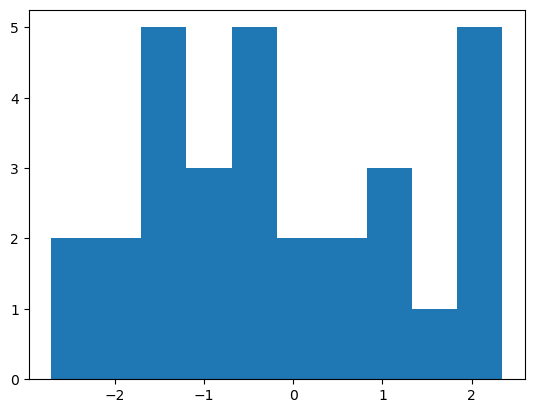

In [1]:
# Generating data with known ground-truth: the values of \mu
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt

RandomState(MT19937(SeedSequence(6)))

N = 30; # number of observations

# prior parameters
theta_0 = np.array([0,0])
sigma_0 = np.array([[5.0**2, 0],
                    [0,      5.0**2]])

# true means
mu = np.array([-1, 1]) # np.random.multivariate_normal(theta_0, sigma_0)
print("true mu = " + str(mu))

# generate data using indicators
z_gen = np.random.randint(0,2, (N))
print("z for generating from bivariate normal = " + str(z_gen))

Y = np.zeros((N))
for ii in range(2):
    Y[z_gen==ii] = np.random.normal(loc=mu[ii],scale=1,size=(np.sum(z_gen==ii)))
print("observable Y = " + str(Y))

plt.hist(Y)
plt.show()

Now that we have a set of Y values, we want to estimate the parameters $\mu$.
We do this by alternately sampling from the conditional posteriors:
$$
p(\mathbb{\mu} | \mathbb{y}, \mathbb{z})
$$
and
$$
p(\mathbb{z} | \mathbb{y}, \mathbb{\mu}) 
$$

In [2]:
from scipy.special import logsumexp

def sample_z_given_y_mu(y, mu):
    log_p_y_given_z = -0.5*(y[:,np.newaxis]-mu[np.newaxis,:])**2
    # log probability of z being 2
    log_p_z_2 = log_p_y_given_z[:,1] - logsumexp(log_p_y_given_z,axis=1)
    z = (-np.random.exponential(size=y.shape) < log_p_z_2) # draws each z as 0 or 1 given the log probability above
    return z

def sample_mu_given_z_y(y, z, theta_0, sigma_0):
    sigma_inv_post = np.linalg.inv(sigma_0)
    theta_post = theta_0.copy()
    for ii in range(2):
        sigma_inv_post[ii,ii] += np.sum(z==ii) 
        theta_post[ii] += np.sum(y[z==ii])
    theta_post = np.linalg.solve(sigma_inv_post, theta_post)
    sigma_post = np.linalg.inv(sigma_inv_post)

    return np.random.multivariate_normal(theta_post, sigma_post)



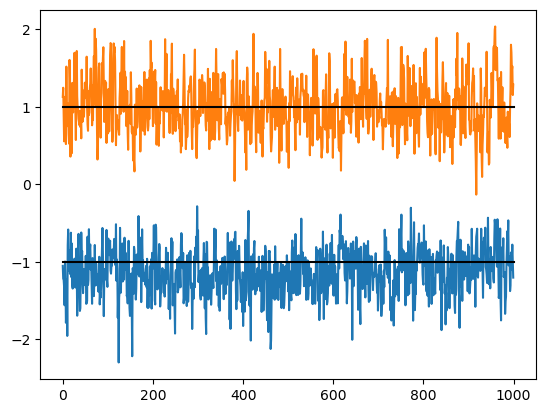

In [3]:
# now we sample
num_samples = 1000;

mu_samples = np.zeros((num_samples,2))
mu_samples.fill(np.nan)
# start of with an initial guess for mu: these percentiles are probably pretty good
mu_init= np.percentile(Y,[25, 75])
mu_current = mu_init.copy()

for sample in range(num_samples):
    # sample z given last mu.
    # I'm not storing the z samples. You could if you wanted, but right now I only care about mu
    z = sample_z_given_y_mu(Y, mu_current);

    # sample
    mu_current = sample_mu_given_z_y(Y,z, theta_0, sigma_0)

    # save sample
    mu_samples[sample,:] = mu_current

plt.plot(mu_samples)
plt.plot([0,num_samples],[mu[0], mu[0]], c='k')
plt.plot([0,num_samples],[mu[1], mu[1]], c='k')
plt.show()
# Note: You may see the two lines flip back and forth a bit
#       This is because the model is only identifiable up to a label: \mu_1 and \mu_2 can be swapped


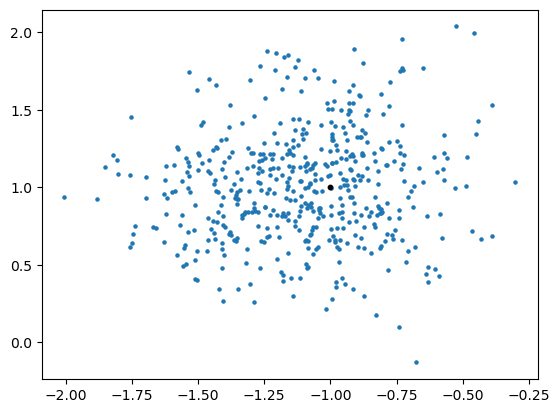

In [4]:
# now to look at the samples
# this is a distribution over plausble values of the mus
# I'll plot the samples and the true values

# note: we want to throw out some initial samples (burn-in period)
burn_in = 500;

plt.scatter(mu_samples[burn_in:,0],mu_samples[burn_in:,1], s=5)
plt.scatter(mu[0],mu[1], s=10, c='k')
plt.show()

In [5]:
# Now we can do some hypothesis testing.
# This model is weird, because the model is only identifiable up to a label: \mu_1 and \mu_2 can be swapped. The stats need to reflect this

# one example of a test: is the difference in means at least some delta
delta = 1.5
diffs = np.abs(mu_samples[burn_in:,0]-mu_samples[burn_in:,1])
p_is_true = np.mean(diffs > delta)
print("posterior probability that the difference in means is at least " + str(delta) + " is " + str(p_is_true))
print("true difference in means: " + str(np.abs(mu[0] - mu[1])))


posterior probability that the difference in means is at least 1.5 is 0.92
true difference in means: 2
